In [1]:
import warnings
warnings.filterwarnings("ignore")

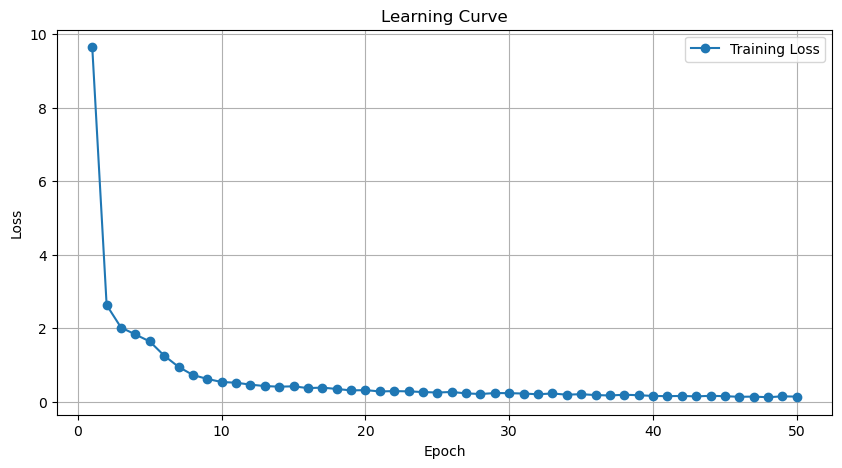

✅ Training finished.

--- Anomaly Score Statistics ---
Normal Scores (mean, std): 0.0112, 0.0044
Abnormal Scores (mean, std): 0.9584, 0.0974


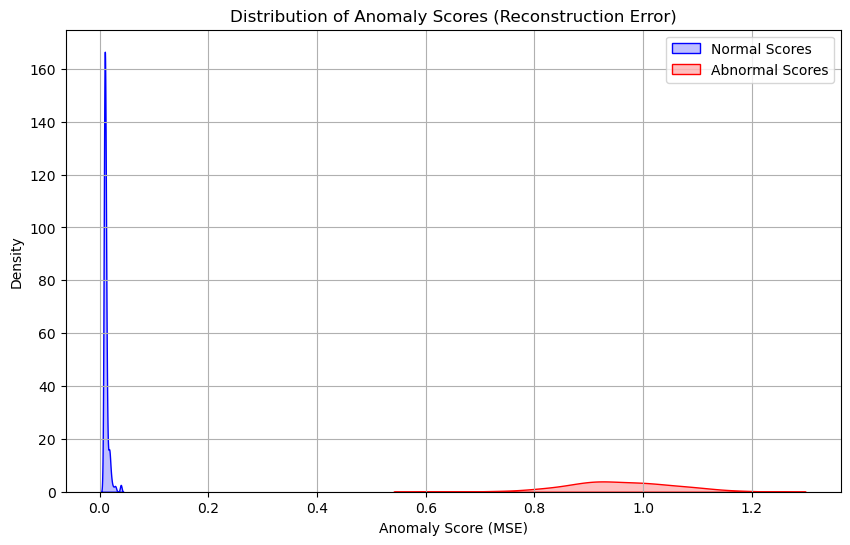

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from IPython.display import display, clear_output
import math
import time

# --- 1. 完全遵循論文設計的 PatchTST 模型 ---

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        self.mean = torch.mean(x, dim=2, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=2, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight.view(1, -1, 1)
            x = x + self.affine_bias.view(1, -1, 1)
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias.view(1, -1, 1)
            x = x / (self.affine_weight.view(1, -1, 1) + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

class PatchTST_Backbone(nn.Module):
    def __init__(self, n_vars, seq_len, patch_len, stride, d_model, n_heads, n_layers, d_ff, dropout, mask_ratio):
        super().__init__()
        self.n_vars = n_vars
        self.patch_len = patch_len
        self.stride = stride
        self.mask_ratio = mask_ratio
        
        self.revin_layer = RevIN(n_vars)
        
        # *** MODIFIED PART ***
        # 修正補丁數量的計算公式，使其與 torch.unfold 的行為一致。
        # torch.unfold 的輸出維度是 floor((L-P)/S) + 1
        self.n_patches = math.floor((seq_len - patch_len) / stride) + 1
        
        self.W_p = nn.Linear(patch_len, d_model)
        self.W_pos = nn.Parameter(torch.randn(1, self.n_patches, d_model))
        
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)
        
        self.head = nn.Linear(d_model, patch_len)

    def forward(self, x):
        B, M, L = x.shape
        
        x = self.revin_layer(x, 'norm')
        
        x = x.reshape(B * M, 1, L)
        
        x_patched = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x_patched = x_patched.squeeze(1)
        
        if self.training:
            mask = torch.rand(x_patched.shape[0], x_patched.shape[1]).to(x.device)
            mask[mask <= self.mask_ratio] = 0
            mask[mask > self.mask_ratio] = 1
            target = x_patched.clone()
            x_patched = x_patched * mask.unsqueeze(-1)
        else:
            mask = torch.ones(x_patched.shape[0], x_patched.shape[1]).to(x.device)
            target = x_patched.clone()

        enc_in = self.W_p(x_patched)
        enc_in = enc_in + self.W_pos
        
        enc_out = self.transformer_encoder(enc_in)
        
        dec_out = self.head(enc_out)
        
        return dec_out, target, mask

# --- (4) (5) (6) (7) (8) (9) Agent Class ---
class Agent:
    def __init__(self, n_vars, seq_len):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.config = {
            "n_vars": n_vars,
            "seq_len": seq_len,
            "patch_len": 12,
            "stride": 12,
            "d_model": 128,
            "n_heads": 16,
            "n_layers": 3,
            "d_ff": 256,
            "dropout": 0.2,
            "mask_ratio": 0.4
        }
        
        self.model = PatchTST_Backbone(**self.config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = nn.MSELoss(reduction='none')

    def train(self, dataloader, epochs):
        self.model.train()
        history = {'loss': []}
        
        print("🚀 Starting training...")
        for epoch in range(epochs):
            epoch_start_time = time.time()
            total_loss = 0
            
            for batch_x in dataloader:
                batch_x = batch_x.to(self.device)
                self.optimizer.zero_grad()
                
                pred, target, mask = self.model(batch_x)
                
                loss = (self.loss_fn(pred, target) * (1 - mask.unsqueeze(-1))).sum() / ((1 - mask).sum() + 1e-8)

                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            history['loss'].append(avg_loss)
            
            epoch_end_time = time.time()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, Time: {epoch_end_time - epoch_start_time:.2f}s")

            if (epoch + 1) % 10 == 0:
                try:
                    clear_output(wait=True)
                except Exception:
                    pass
                
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 2), history['loss'], label='Training Loss', marker='o')
                ax.set_title('Learning Curve')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                plt.grid(True)
                plt.show()

        print("✅ Training finished.")

    def predict(self, dataloader):
        self.model.eval()
        anomaly_scores = []
        
        with torch.no_grad():
            for batch_x in dataloader:
                batch_x = batch_x.to(self.device)
                B, M, L = batch_x.shape

                pred, target, _ = self.model(batch_x)
                
                loss_matrix = self.loss_fn(pred, target)
                sample_loss = loss_matrix.mean(dim=[-1, -2])
                sample_loss = sample_loss.reshape(B, M).mean(dim=-1)
                
                anomaly_scores.extend(sample_loss.cpu().numpy())
                
        return np.array(anomaly_scores)


# --- (10) 主程式：產生資料、訓練、測試、畫圖 ---

def normal_data_generator():
    base = float(np.random.normal(60, 2, size=(1,)))
    series1_1 = (np.random.normal(0, .5, size=(48,)) + base).tolist()
    base = float(np.random.normal(70, 2, size=(1,)))
    series2_1 = ([base] * 48).copy()
    base = float(np.random.normal(-20, 2, size=(1,)))
    series1_2 = (np.random.normal(0, .01, size=(52,)) + base).tolist()
    base = float(np.random.normal(60, 2, size=(1,)))
    series2_2 = (np.random.normal(0, .5, size=(52 + 30,)) + base).tolist()
    base = float(np.random.normal(60, 2, size=(1,)))
    series1_3 = ([base] * 30).copy()
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size=(1,)))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size=(1,)))
    series1 = (np.random.normal(0, .5, size=(48 + 52 + 30,)) + base).tolist()
    base = float(np.random.normal(60, 2, size=(1,)))
    series2_1 = ([base] * 48).copy()
    base = float(np.random.normal(-20, 2, size=(1,)))
    series2_2 = (np.random.normal(0, .01, size=(52,)) + base).tolist()
    base = float(np.random.normal(60, 2, size=(1,)))
    series2_3 = ([base] * 30).copy()
    series2 = series2_1 + series2_2 + series2_3
    flag = float(np.random.normal(0, .5, size=(1,)))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32).T

if __name__ == '__main__':
    N_TRAIN = 1000
    N_TEST = 200
    
    train_data = [normal_data_generator() for _ in range(N_TRAIN)]
    test_normal_data = [normal_data_generator() for _ in range(N_TEST)]
    test_abnormal_data = [abnormal_data_generator() for _ in range(N_TEST)]
    
    train_dataset = TimeSeriesDataset(train_data)
    test_normal_dataset = TimeSeriesDataset(test_normal_data)
    test_abnormal_dataset = TimeSeriesDataset(test_abnormal_data)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_normal_loader = DataLoader(test_normal_dataset, batch_size=32, shuffle=False)
    test_abnormal_loader = DataLoader(test_abnormal_dataset, batch_size=32, shuffle=False)
    
    sample_data = train_data[0]
    seq_len, n_vars = sample_data.shape
    
    agent = Agent(n_vars=n_vars, seq_len=seq_len)
    agent.train(dataloader=train_loader, epochs=50)
    
    normal_scores = agent.predict(test_normal_loader)
    abnormal_scores = agent.predict(test_abnormal_loader)
    
    print("\n--- Anomaly Score Statistics ---")
    print(f"Normal Scores (mean, std): {np.mean(normal_scores):.4f}, {np.std(normal_scores):.4f}")
    print(f"Abnormal Scores (mean, std): {np.mean(abnormal_scores):.4f}, {np.std(abnormal_scores):.4f}")

    plt.figure(figsize=(10, 6))
    sns.kdeplot(normal_scores, label='Normal Scores', fill=True, color='blue')
    sns.kdeplot(abnormal_scores, label='Abnormal Scores', fill=True, color='red')
    plt.title('Distribution of Anomaly Scores (Reconstruction Error)')
    plt.xlabel('Anomaly Score (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()